In [15]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import getWorkingHRDfParquet, getHRIntervals, intervalOverlap, getHRsForTimePeriods
from datetime import date, time, timedelta
import pandas as pd
import numpy as np

In [4]:
appleHRDf = getWorkingHRDfParquet('apple')
print(len(appleHRDf))
dataToFit = appleHRDf[(appleHRDf.index.date == date(2024,9,12)) &
                      (appleHRDf.index.time < time(0,20,0))].copy()
print(len(dataToFit))

567895
241


In [13]:
dataToFit['timeToNext'] = (dataToFit.index.to_series() - 
                            dataToFit.index.to_series().shift(1)
                            ).dt.total_seconds()
dataToFit.dropna(inplace=True)
dataToFit.head(2)

,value,timeToNext
sampleDT,,
2024-09-12 00:00:15-07:00,57.0,6.0
2024-09-12 00:00:19-07:00,57.0,4.0


In [17]:
dataToFit['dummyTime'] = np.arange(len(dataToFit))
dataToFit.head(2)

,value,timeToNext,dummyTime
sampleDT,,,
2024-09-12 00:00:15-07:00,57.0,6.0,0
2024-09-12 00:00:19-07:00,57.0,4.0,1


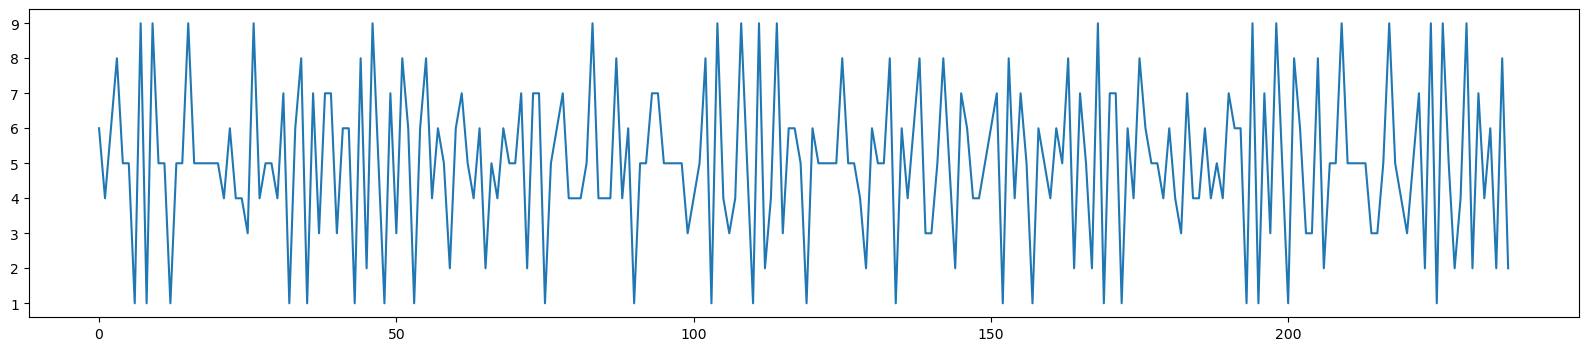

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,4))
plt.plot(dataToFit['dummyTime'], dataToFit['timeToNext'])

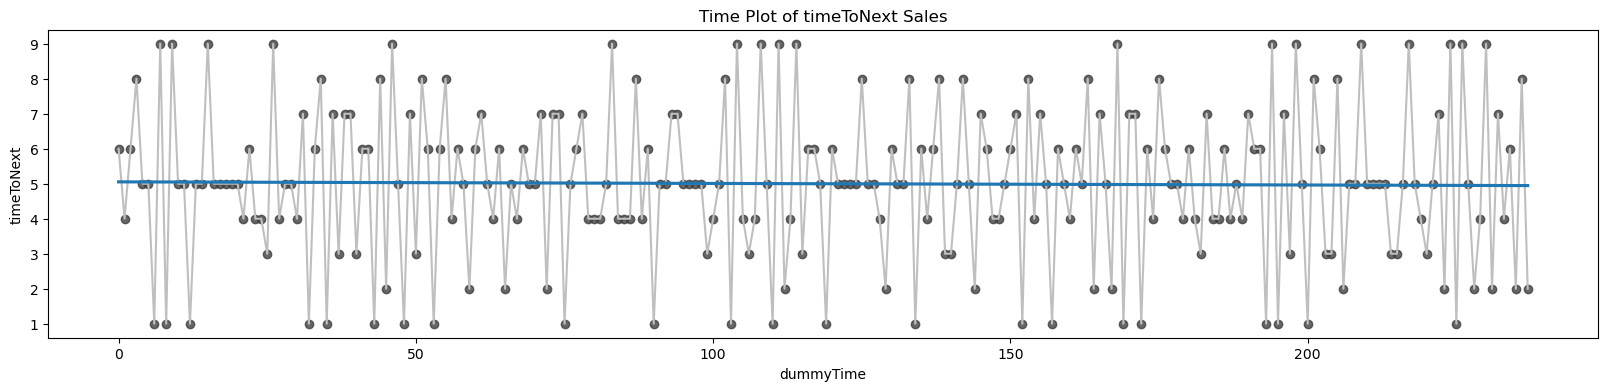

In [25]:

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,4))
ax.plot('dummyTime', 'timeToNext', data=dataToFit, color='0.75')
ax = sns.regplot(x='dummyTime', y='timeToNext', data=dataToFit, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of timeToNext Sales')

In [32]:
dataToFit.index = dataToFit['dummyTime']

In [33]:
from sklearn.linear_model import LinearRegression


# YOUR CODE HERE: Create training data
X = dataToFit.loc[:,['dummyTime']]  # features
y = dataToFit.loc[:,"timeToNext"]  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

dummyTime
0      5.053163
1      5.052714
2      5.052265
3      5.051817
4      5.051368
         ...   
233    4.948632
234    4.948183
235    4.947735
236    4.947286
237    4.946837
Length: 238, dtype: float64

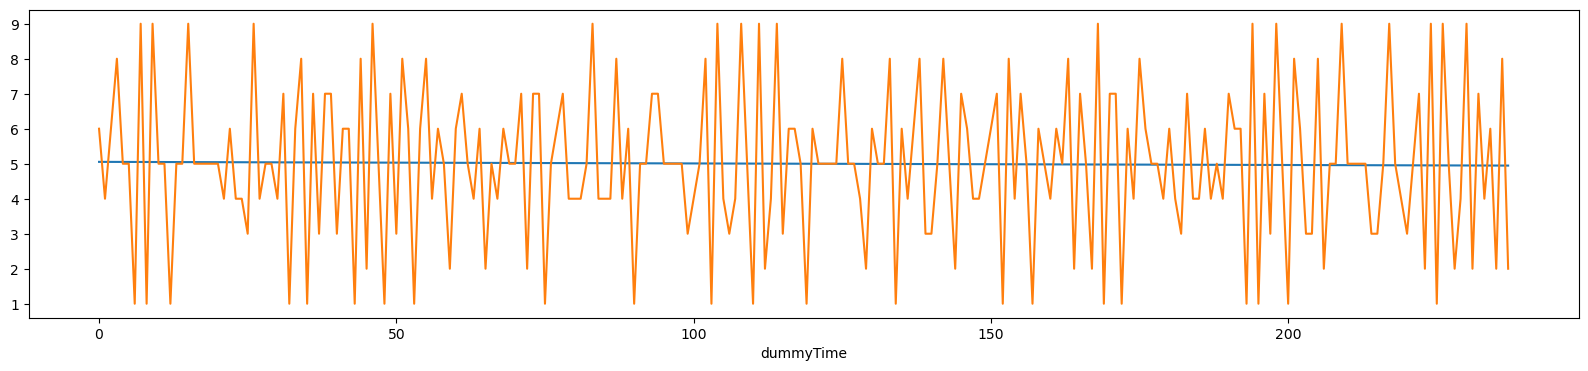

In [34]:
fig, ax = plt.subplots(figsize=(20,4))
ax = y_pred.plot()
plt.plot(dataToFit['dummyTime'], dataToFit['timeToNext'])
plt.show()

In [36]:
# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = dataToFit["timeToNext"].shift(1)

dataToFit['lag_1'] = lag_1  # add to dataframe

X = dataToFit.loc[:, ['lag_1']].dropna()  # features
y = dataToFit.loc[:, 'timeToNext']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X,y)
# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Lag Plot of timeToNext ')

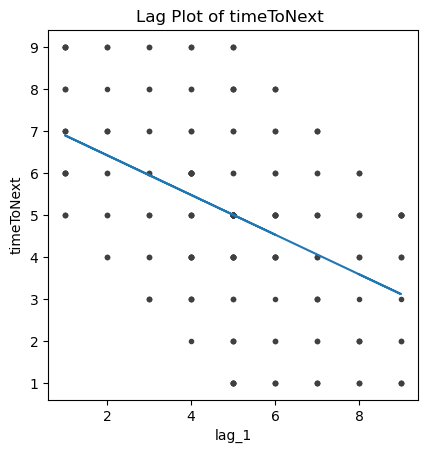

In [39]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('timeToNext')
ax.set_xlabel('lag_1')
ax.set_title('Lag Plot of timeToNext ')

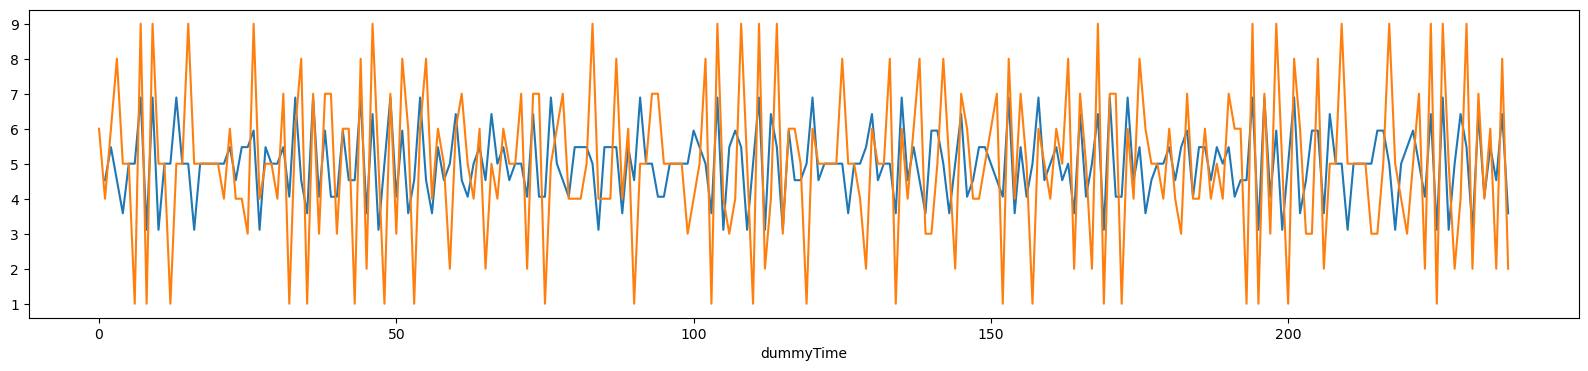

In [37]:
fig, ax = plt.subplots(figsize=(20,4))
ax = y_pred.plot()
plt.plot(dataToFit['dummyTime'], dataToFit['timeToNext'])
plt.show()